In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('df.csv')
df.head()

,Month,LA1_Comdty_actual,LA1 Comdty_model_12m,LA1 Comdty_forecast_12m
0,1/1/2019,1901.00,1901.7776,NaN
1,2/1/2019,1894.75,1893.9950,NaN
2,3/1/2019,1900.25,1906.3896,NaN
3,4/1/2019,1773.00,1798.0258,NaN
4,5/1/2019,1777.50,1790.9158,NaN


# ERROR PROPAGATION
# Confidence level 80% - 90%

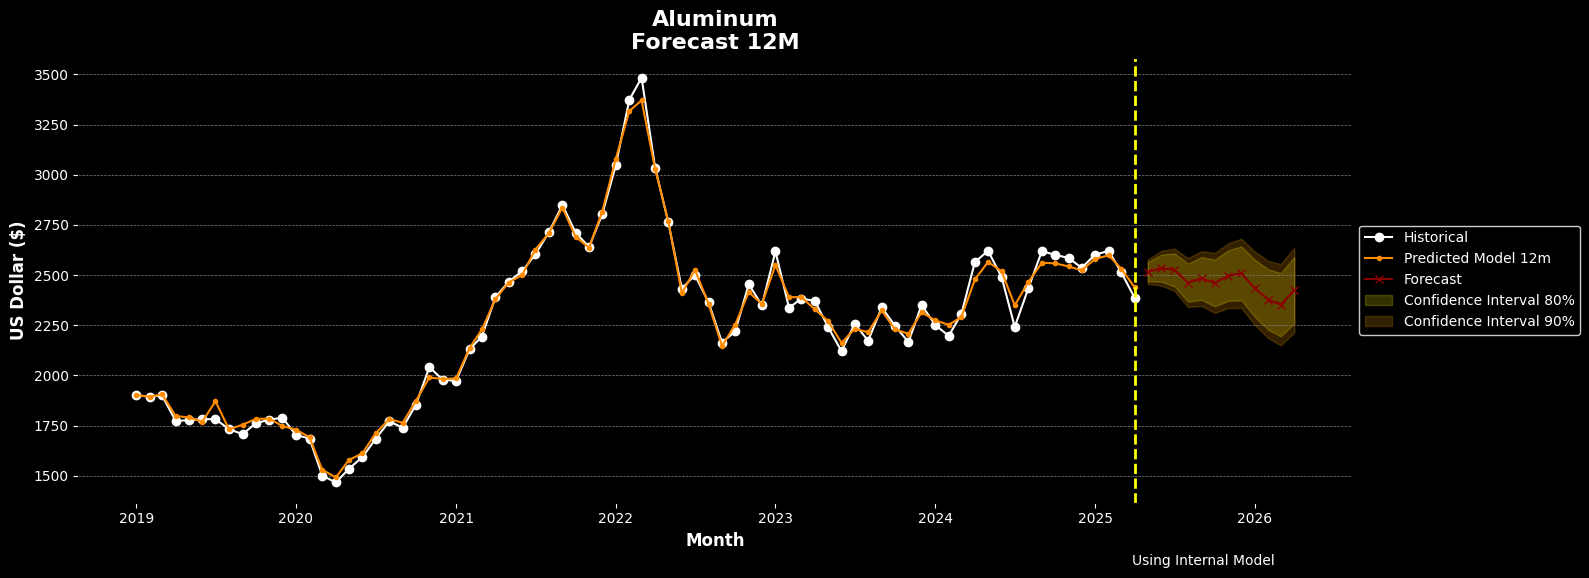

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert the 'Month' column to datetime format
df['Month'] = pd.to_datetime(df['Month'])

# Calculate historical errors
df['Error'] = df['LA1_Comdty_actual'] - df['LA1 Comdty_model_12m']
historical_std_error = df['Error'].std()

# Forecast horizon
forecast_horizon = len(df[df['LA1 Comdty_forecast_12m'].notnull()])

# Calculate error propagation (square root of the sum of variances)
time_effect = np.sqrt(np.arange(1, forecast_horizon + 1))  # Time effect
propagated_error = historical_std_error * time_effect  # Error propagation

# Calculate confidence intervals (80% and 90%)
confidence_levels = [0.80, 0.90]
z_scores = [1.28, 1.64]  # Z-scores for 80% and 90%

# Adjust to model predictions
forecast_data = df[df['LA1 Comdty_forecast_12m'].notnull()].copy()
for i, cl in enumerate(confidence_levels):
    z = z_scores[i]  # Z-score associated with the confidence level
    forecast_data[f'Lower_CI_{int(cl*100)}'] = forecast_data['LA1 Comdty_forecast_12m'] - z * propagated_error
    forecast_data[f'Upper_CI_{int(cl*100)}'] = forecast_data['LA1 Comdty_forecast_12m'] + z * propagated_error

# Create the figure with a black background
fig, ax = plt.subplots(figsize=(16, 6), facecolor='black')
ax.set_facecolor('black')

# Plot historical data
historical_data = df[df['LA1_Comdty_actual'].notnull()]
ax.plot(historical_data['Month'], historical_data['LA1_Comdty_actual'], label='Historical', color='white', marker='o')
ax.plot(historical_data['Month'], historical_data['LA1 Comdty_model_12m'], label='Predicted Model 12m', color='darkorange', linestyle='-', marker='.')

# Plot forecasts
ax.plot(forecast_data['Month'], forecast_data['LA1 Comdty_forecast_12m'], label='Forecast', color='darkred', marker='x')

# Plot confidence intervals
colors = {80: 'yellow', 90: 'orange'}
for cl in confidence_levels:
    ax.fill_between(forecast_data['Month'], forecast_data[f'Lower_CI_{int(cl*100)}'], forecast_data[f'Upper_CI_{int(cl*100)}'], alpha=0.2, color=colors[int(cl*100)], label=f'Confidence Interval {int(cl*100)}%')

# Graph configuration
ax.set_title("Aluminum\nForecast 12M", fontsize=16, fontweight="bold", color='white')
ax.set_xlabel('Month', fontsize=12, fontweight="bold", color='white')
ax.set_ylabel("US Dollar ($)", fontsize=12, fontweight="bold", color='white')
ax.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)
ax.axvline(x=pd.to_datetime("2025-04-01"), color="yellow", linestyle="--", linewidth=2)

# Legend
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), facecolor='black', edgecolor='white')
for text in legend.get_texts():
    text.set_color('white')

# Axis configuration
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

# Additional text
fig.text(0.8, 0.05, "Using Internal Model", fontsize=10, ha="right", color="white")

# Layout adjustment
plt.tight_layout(rect=[0, 0.05, 1, 1])

# Show the plot
plt.show()

# BOOSTRAP SIMULATION -  Time-Adjusted Error Scaling
## Confidence level 80% - 90%

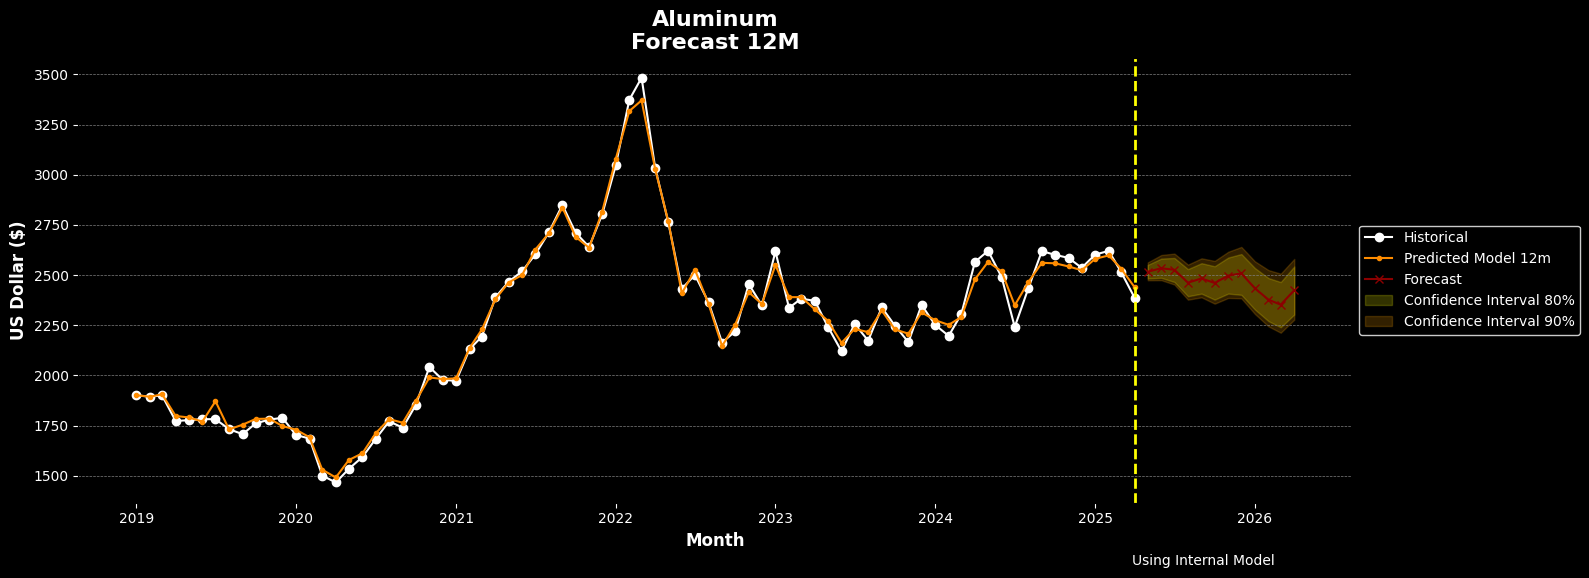

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert the 'Month' column to datetime format
df['Month'] = pd.to_datetime(df['Month'])

# Calculate historical errors
df['Error'] = df['LA1_Comdty_actual'] - df['LA1 Comdty_model_12m']
historical_std_error = df['Error'].std()

# Simulation configuration
num_simulations = 1000  # Number of simulations
forecast_horizon = len(df[df['LA1 Comdty_forecast_12m'].notnull()])  # Forecast horizon

# Simulate historical errors (sampling with replacement)
simulated_errors = np.random.choice(df['Error'].dropna(), size=(num_simulations, forecast_horizon), replace=True)

# Introduce the time effect with scaling by the square root of time
time_effect = np.sqrt(np.arange(1, forecast_horizon + 1))  # Scaling by square root of time
scaled_errors = simulated_errors * time_effect  # Adjust errors according to the horizon
scaled_errors *= 0.8  # Reduce the overall amplitude of the intervals

# Calculate percentiles for 80% and 90% confidence intervals
confidence_levels = [0.80, 0.90]
percentiles = [(1 - cl) / 2 * 100 for cl in confidence_levels] + [(1 + cl) / 2 * 100 for cl in confidence_levels]

# Calculate the lower and upper bounds for each confidence level
bounds = np.percentile(scaled_errors, percentiles, axis=0)

# Adjust to model predictions
forecast_data = df[df['LA1 Comdty_forecast_12m'].notnull()].copy()
for i, cl in enumerate(confidence_levels):
    forecast_data[f'Lower_CI_{int(cl*100)}'] = forecast_data['LA1 Comdty_forecast_12m'].values + bounds[i]
    forecast_data[f'Upper_CI_{int(cl*100)}'] = forecast_data['LA1 Comdty_forecast_12m'].values + bounds[i + len(confidence_levels)]

# Create the figure with a black background
fig, ax = plt.subplots(figsize=(16, 6), facecolor='black')
ax.set_facecolor('black')

# Plot historical data
historical_data = df[df['LA1_Comdty_actual'].notnull()]
ax.plot(historical_data['Month'], historical_data['LA1_Comdty_actual'], label='Historical', color='white', marker='o')
ax.plot(historical_data['Month'], historical_data['LA1 Comdty_model_12m'], label='Predicted Model 12m', color='darkorange', linestyle='-', marker='.')

# Plot forecasts
ax.plot(forecast_data['Month'], forecast_data['LA1 Comdty_forecast_12m'], label='Forecast', color='darkred', marker='x')

# Plot confidence intervals at 80% and 90%
colors = {80: 'yellow', 90: 'orange'}
for cl in confidence_levels:
    ax.fill_between(forecast_data['Month'], forecast_data[f'Lower_CI_{int(cl*100)}'], forecast_data[f'Upper_CI_{int(cl*100)}'], alpha=0.2, color=colors[int(cl*100)], label=f'Confidence Interval {int(cl*100)}%')

# Graph configuration
ax.set_title("Aluminum\nForecast 12M", fontsize=16, fontweight="bold", color='white')
ax.set_xlabel('Month', fontsize=12, fontweight="bold", color='white')
ax.set_ylabel("US Dollar ($)", fontsize=12, fontweight="bold", color='white')
ax.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)
ax.axvline(x=pd.to_datetime("2025-04-01"), color="yellow", linestyle="--", linewidth=2)

# Legend configuration
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), facecolor='black', edgecolor='white')
for text in legend.get_texts():
    text.set_color('white')

# Configure axis ticks in white
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

# Additional text
fig.text(0.8, 0.05, "Using Internal Model", fontsize=10, ha="right", color="white")

# Layout adjustment
plt.tight_layout(rect=[0, 0.05, 1, 1])

# Show the plot
plt.show()

# Monte Carlo Simulation with Bootstrap Resampling
## Confidence level 80% - 90%

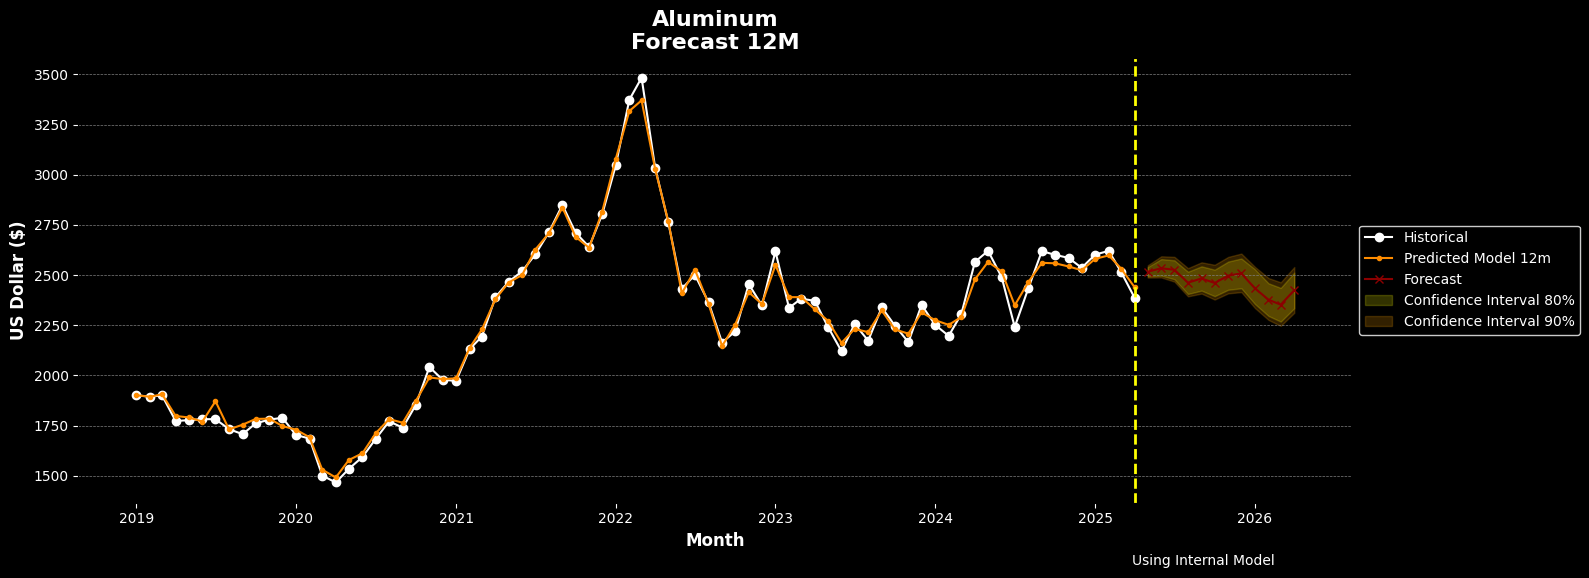

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert the 'Month' column to datetime format
df['Month'] = pd.to_datetime(df['Month'])

# Calculate historical errors
df['Error'] = df['LA1_Comdty_actual'] - df['LA1 Comdty_model_12m']
historical_std_error = df['Error'].std()

# Configuration for simulations
num_simulations = 1000  # Number of simulations
forecast_horizon = len(df[df['LA1 Comdty_forecast_12m'].notnull()])  # Forecast horizon

# Simulate historical errors (sampling with replacement)
simulated_errors = np.random.choice(df['Error'].dropna(), size=(num_simulations, forecast_horizon), replace=True)


# Introduce the time effect with adjusted scaling
time_effect = np.log(np.arange(1, forecast_horizon + 1) + 1)  # Logarithmic scaling
scaled_errors = simulated_errors * time_effect  # Scale errors according to the horizon
scaled_errors *= 0.8  # Reduce the overall amplitude of the intervals


# Calculate percentiles for 80% and 90% confidence intervals
confidence_levels = [0.80, 0.90]
percentiles = [(1 - cl) / 2 * 100 for cl in confidence_levels] + [(1 + cl) / 2 * 100 for cl in confidence_levels]

# Calculate lower and upper bounds for each confidence level
bounds = np.percentile(scaled_errors, percentiles, axis=0)

# Adjust to model predictions
forecast_data = df[df['LA1 Comdty_forecast_12m'].notnull()].copy()
for i, cl in enumerate(confidence_levels):
    forecast_data[f'Lower_CI_{int(cl*100)}'] = forecast_data['LA1 Comdty_forecast_12m'].values + bounds[i]
    forecast_data[f'Upper_CI_{int(cl*100)}'] = forecast_data['LA1 Comdty_forecast_12m'].values + bounds[i + len(confidence_levels)]

# Create the figure with a black background
fig, ax = plt.subplots(figsize=(16, 6), facecolor='black')

# Set the black background for the axes
ax.set_facecolor('black')

# Plot historical data
historical_data = df[df['LA1_Comdty_actual'].notnull()]
ax.plot(historical_data['Month'], historical_data['LA1_Comdty_actual'], 
        label='Historical', color='white', marker='o')
ax.plot(historical_data['Month'], historical_data['LA1 Comdty_model_12m'], 
        label='Predicted Model 12m', color='darkorange', linestyle='-', marker='.')

# Plot forecasts
ax.plot(forecast_data['Month'], forecast_data['LA1 Comdty_forecast_12m'], 
        label='Forecast', color='darkred', marker='x')

# Plot confidence intervals at 80% and 90%
colors = {
    80: 'yellow',  # Color for the 80% interval
    90: 'orange'   # Color for the 90% interval
}

for cl in confidence_levels:
    ax.fill_between(forecast_data['Month'], 
                    forecast_data[f'Lower_CI_{int(cl*100)}'], 
                    forecast_data[f'Upper_CI_{int(cl*100)}'], 
                    alpha=0.2, color=colors[int(cl*100)],
                    label=f'Confidence Interval {int(cl*100)}%')

# Graph configuration
ax.set_title("Aluminum\nForecast 12M", fontsize=16, fontweight="bold", color='white', loc='center')
ax.set_xlabel('Month', fontsize=12, fontweight="bold", color='white')
ax.set_ylabel("US Dollar ($)", fontsize=12, fontweight="bold", color='white')
ax.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)
ax.axvline(x=pd.to_datetime("2025-04-01"), color="yellow", linestyle="--", linewidth=2)

# Legend configuration
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), facecolor='black', edgecolor='white')
for text in legend.get_texts():
    text.set_color('white')

# Configure axis ticks in white
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

# Additional text
fig.text(0.8, 0.05, "Using Internal Model", fontsize=10, ha="right", color="white")

# Layout adjustment
plt.tight_layout(rect=[0, 0.05, 1, 1])

# Show the plot
plt.show()
